# Аналитика в Яндекс.Афише

Задание: помочь маркетологам оптимизировать маркетинговые затраты.

В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

# Изучение данных и подготовка их к анализу


Загрузим данные о визитах, заказах и расходах в переменные. 

In [492]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 

visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

## VISITS

Изучим таблицу `visits` (лог сервера с информацией о посещениях сайта)

In [493]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Переименуем названия слобцов:

In [494]:
visits.rename(columns={'Device': 'device', 
                       'End Ts': 'end_ts', 
                       'Source Id': 'source_id',  
                       'Start Ts': 'start_ts',
                       'Uid': 'uid',}, inplace=True)
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Изменим тип данных в столбцах `end_ts` и `start_ts` на тип `datetime`

In [495]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
#visits.info()

In [496]:
print('Логи в таблице visits с {} по {}'.format(visits['start_ts'].min(), visits['start_ts'].max()))

Логи в таблице visits с 2017-06-01 00:01:00 по 2018-05-31 23:59:00


## ORDERS

Изучим данные о заказах

In [497]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Приведем названия столбцов к единому нижнему регистру:

In [498]:
orders.columns = orders.columns.str.lower()
orders.rename(columns={'buy ts': 'buy_ts'}, inplace=True)
#print(orders.info())

Изменим тип данных в столбце `buy_ts` на тип `datetime`

In [499]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
print(orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None


In [500]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


## COSTS

Изучим информацию о затратах на маркетинг.

In [501]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Изменим тип данных в столбце `dt` на тип `datetime`

In [502]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [503]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


# Метрики и отчеты
Посчитаем метрики и построим отчеты по направлениям Продукт, Продажи и Маркетинг

# <font color=green>Анализ продуктовых метрик</font>

Посмотрим, сколько людей пользуются сервисом в день, неделю, месяц. Для начала выделим из дат день/неделю/месяц/год

In [504]:
visits['start_ts_date'] = visits['start_ts'].dt.date
visits['end_ts_date'] = visits['end_ts'].dt.date
visits['start_ts_week'] =  visits['start_ts'].dt.week
visits['start_ts_month'] = visits['start_ts'].dt.month
visits['start_ts_year'] = visits['start_ts'].dt.year


In [505]:
visits['end_ts_date'] = pd.to_datetime(visits['end_ts_date'])
visits['start_ts_date'] = pd.to_datetime(visits['start_ts_date'])
#visits.info()

Посчитаем метрики пользовательской активности - `dau`, `mau`, `wau`:

Пользователей в день в среднем: 907
Пользователей в неделю в среднем: 5716
Пользователей в месяц в среднем: 23228


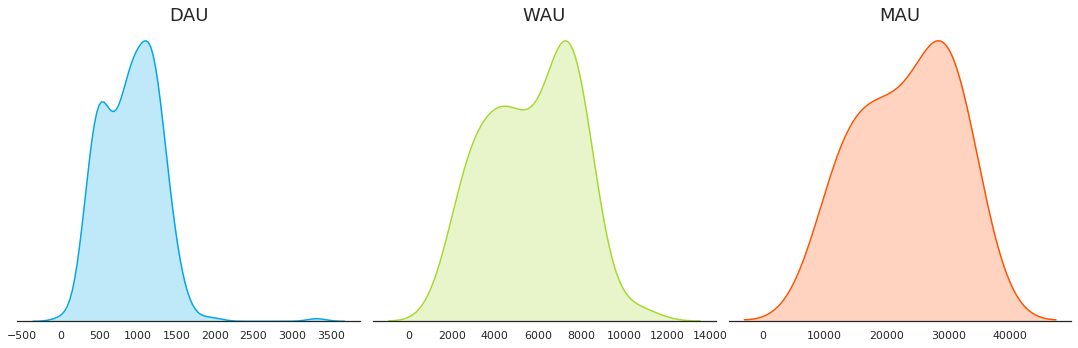

In [506]:
dau = visits.groupby('start_ts_date').agg({'uid': 'nunique'})
wau = visits.groupby(['start_ts_year', 'start_ts_week']).agg({'uid': 'nunique'})  
mau = visits.groupby(['start_ts_year', 'start_ts_month']).agg({'uid': 'nunique'})

print('Пользователей в день в среднем:', int(dau.mean()))
print('Пользователей в неделю в среднем:', int(wau.mean()))
print('Пользователей в месяц в среднем:', int(mau.mean()))

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.despine(left=True)

# Plots
sns.distplot(dau, hist=False, color="#00a6e7", kde_kws={"shade": True}, ax=axes[0]).set_title('DAU', fontsize=18)
sns.distplot(wau, hist=False, color="#a7d82e", kde_kws={"shade": True}, ax=axes[1]).set_title('WAU', fontsize=18)
sns.distplot(mau, hist=False, color="#ff5200", kde_kws={"shade": True}, ax=axes[2]).set_title('MAU', fontsize=18)

plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

Посчитаем сколько в среднем сессий в день совершают пользователи:

In [507]:
sessions_per_day = visits.groupby('start_ts_date')['start_ts_date'].count()
print('Пользователи совершают в среднем {} сессий в день'.format(int(sessions_per_day.mean())))

Пользователи совершают в среднем 987 сессий в день


Посмотрим, сколько длится одна сессия. Посчитаем среднюю продолжительность сессии - `ASL`

In [508]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
print('Средняя прододжительность сессии(ASL):', int((visits['session_duration_sec'].mean()/60)), 'минут')

Средняя прододжительность сессии(ASL): 10 минут


Посмотрим на распределение:

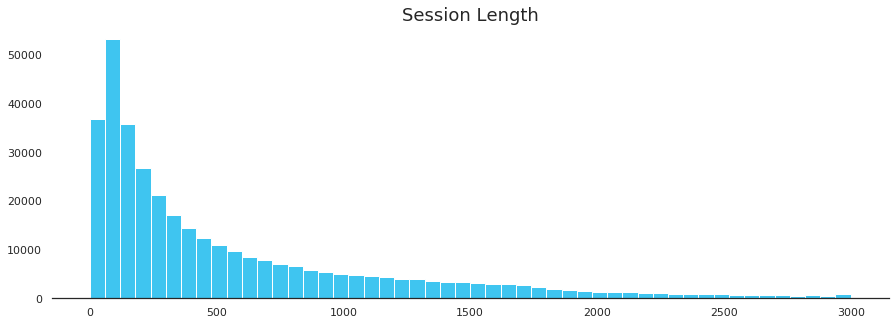

In [509]:
plt.figure(figsize=(15, 5))
plt.title('Session Length', fontsize=18)
visits['session_duration_sec'].hist(bins=50, range=(0, 3000), grid=False, color='#3fc5f0')
sns.despine(left=True)
plt.show()

Рассчитаем моду (значение в выборке, которое встречается чаще всего):

In [510]:
print(visits['session_duration_sec'].mode())

0    60
dtype: int64


Чаще всего сессия длится 1 минуту, судя по распределению большая часть значений располагается в пределах 300 секунд (5 минут). 

## Как часто люди возвращаются?

Чтобы ответить на этот вопрос необходимо посчитать коэффициент удержания `Retention Rate`

Определим событие и период — на их основе сформируем когорту. Возьмём дату начала первой сессии.
Эти данные запишем в `first_ts_dates`. 

In [511]:
first_ts_dates = visits.groupby('uid')['start_ts'].min()
first_ts_dates.name = 'first_ts_datetime'
first_ts_dates.head()

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: first_ts_datetime, dtype: datetime64[ns]

Объединим его с исходным датафреймом `visits`:

In [512]:
visits = visits.join(first_ts_dates,on='uid', lsuffix='_left')

Получим столбцы с первым месяцем в который произошло событие 

In [513]:
visits['ts_month'] = visits['start_ts_date'].astype('datetime64[M]')
visits['first_ts_month'] = visits['first_ts_datetime'].astype('datetime64[M]')
display(visits.head())


,device,end_ts,source_id,start_ts,uid,start_ts_date,end_ts_date,start_ts_week,start_ts_month,start_ts_year,session_duration_sec,first_ts_datetime,ts_month,first_ts_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-20,51,12,2017,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,8,2,2018,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,26,7,2017,0,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-20,20,5,2018,1440,2018-03-09 20:05:00,2018-05-01,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-27,52,12,2017,0,2017-12-27 14:06:00,2017-12-01,2017-12-01


Теперь для каждой строки датафрейма можно рассчитать `lifetime` пользователя в рамках когорты. Обратимся к константе `np.timedelta64(1,'M')`:

In [514]:
visits['cohort_lifetime'] = visits['ts_month'] - visits['first_ts_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype(int)

visits.head()

,device,end_ts,source_id,start_ts,uid,start_ts_date,end_ts_date,start_ts_week,start_ts_month,start_ts_year,session_duration_sec,first_ts_datetime,ts_month,first_ts_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-20,51,12,2017,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,8,2,2018,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,26,7,2017,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-20,20,5,2018,1440,2018-03-09 20:05:00,2018-05-01,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-27,52,12,2017,0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0


Сгруппируем данные, посчитаем для каждой когорты количество пользователей на определённый «месяц жизни». Чтобы найти `Retention Rate`, нужно получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждый следующий месяц.

In [515]:
# Группируем данные по когорте и lifetime. 
# Считаем количество активных пользователей на месяц

cohorts_ts = visits.groupby(['first_ts_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
#print(cohorts_ts)

# Проверка количества визитов

visits_pivot = visits.pivot_table(index='first_ts_month',columns='cohort_lifetime',values='uid',aggfunc='nunique')
display(visits_pivot.fillna(''))

# Найдём исходное количество пользователей в когорте, возбмем их число на нулевой месяц

inital_users_count = cohorts_ts[cohorts_ts['cohort_lifetime'] == 0][['first_ts_month','uid']]
inital_users_count = inital_users_count.rename(columns={'uid':'cohort_users'})
cohorts_ts = cohorts_ts.merge(inital_users_count,on='first_ts_month')

# Разделим число пользователей в каждый следующий месяц на исходное число пользователей, получим Retention Rate   

cohorts_ts['retention'] = cohorts_ts['uid']/cohorts_ts['cohort_users']
retention_pivot = cohorts_ts.pivot_table(index='first_ts_month',columns='cohort_lifetime',values='retention',aggfunc='sum')


cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_ts_month,,,,,,,,,,,,
2017-06-01,13259.0,1043,713,814,909,947,809,766,694,674,539,596
2017-07-01,13140.0,737,674,738,765,633,596,601,510,376,361,
2017-08-01,10181.0,783,640,639,510,448,370,402,284,265,,
2017-09-01,16704.0,1428,1156,847,658,632,599,404,381,,,
2017-10-01,25977.0,2042,1357,1012,890,837,555,529,,,,
2017-11-01,27248.0,2133,1202,1054,919,638,594,,,,,
2017-12-01,25268.0,1410,960,786,512,481,,,,,,
2018-01-01,22624.0,1351,890,565,458,,,,,,,
2018-02-01,22197.0,1267,565,446,,,,,,,,


Визуализируем `Retention` с помощью тепловой карты

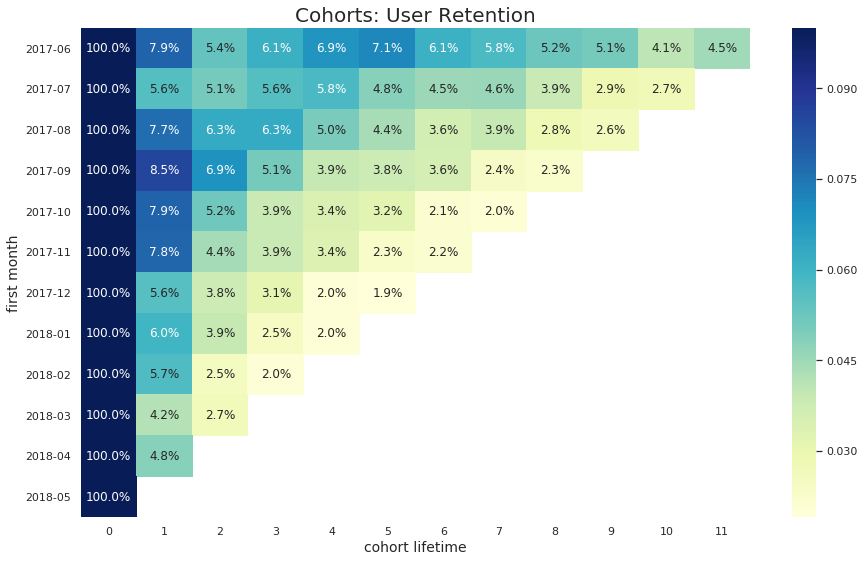

In [516]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Cohorts: User Retention', fontsize=20)
sns.heatmap(retention_pivot, cmap="YlGnBu", annot=True, fmt='.1%',  vmax=0.1, linecolor='gray', yticklabels=retention_pivot.index.strftime('%Y-%m'))
plt.ylabel('first month', fontsize=14)
plt.xlabel('cohort lifetime', fontsize=14)
plt.show()

Начиная с сентябрьской когорты `Retention Rate` постепенно убывает по когортам с течением времени. Если для когорты пользователей, пришедших в сентябре `Retention Rate` составляет 8,5%, то для пользователей, пришедших в марте уже в два раза меньше - 4,2%. В первой когорте пользователи удерживались лучше всего, на 12 месяце жизни когорты показатель 4,5 - это больше, чем на старте мартовской когорты. С каждой новой когортой поведение покупателей меняется.

# <font color=green>Анализ метрик продаж</font>

- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)


## Когда люди начинают покупать?

Вариантов решения данной задачи может быть несколько. Например, можно посчитать сколько времени проходит с начала первой сессии до покупки.

Найдем дату и время первой сессии для каждого пользователя, запишем в `first_ts_dates`:

In [517]:
first_ts_dates = visits.groupby('uid')['start_ts'].min()
first_ts_dates.name = 'first_ts_datetime'
first_ts_dates.head()

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: first_ts_datetime, dtype: datetime64[ns]

In [518]:
# Добавим информацию о первых визитах пользователей в таблицу с заказами

orders = orders.merge(first_ts_dates, on='uid')
orders.head()

,buy_ts,revenue,uid,first_ts_datetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00


Посчитаем сколько секунд прошло от момента первой сессии пользователя до покупки

In [519]:
orders['start_to_buy_sec'] = (orders['buy_ts'] - orders['first_ts_datetime']).dt.seconds
orders.head()

,buy_ts,revenue,uid,first_ts_datetime,start_to_buy_sec
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,60
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,660
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,120
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,900
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,1620


Посмотрим на распределение

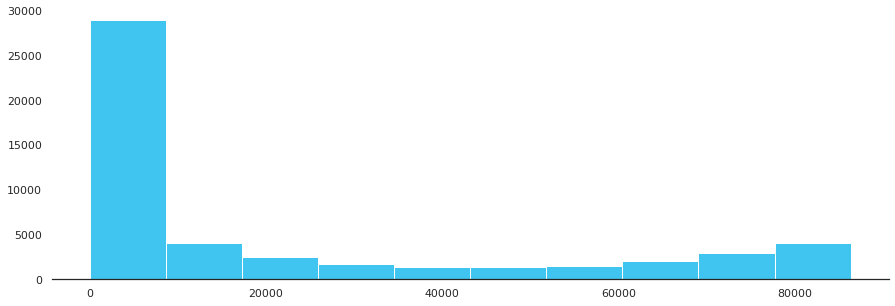

In [520]:
plt.figure(figsize=(15, 5))
orders['start_to_buy_sec'].hist(bins=10, grid=False, color='#3fc5f0')
orders['start_to_buy_sec'].describe()
sns.despine(left=True)
plt.show()

Посмотрим более детально на распределение в диапазоне от 0 до 4000

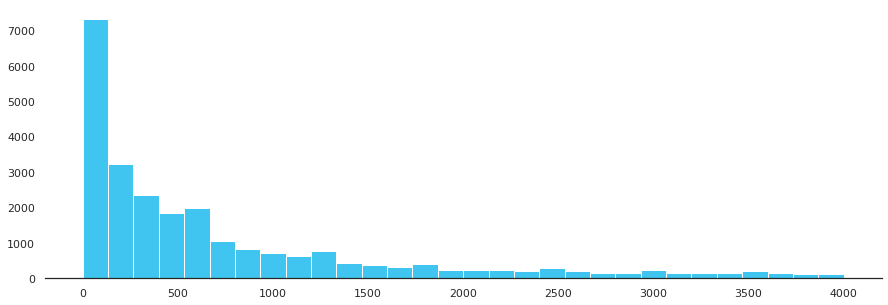

In [521]:
plt.figure(figsize=(15, 5))
orders['start_to_buy_sec'].hist(bins=30, range=(0,4000), grid=False, color='#3fc5f0')
sns.despine(left=True)
plt.show()

In [522]:
orders['start_to_buy_sec'].value_counts().head(10)

60     2687
0      2486
120    2142
180    1729
240    1502
300    1251
360    1108
420    1012
480     838
540     785
Name: start_to_buy_sec, dtype: int64

Большая часть значений распределяется в промежутке от 0 до 500 секунд, то есть большей части пользователей нужно менее 10 мин, чтобы совершить покупку. При этом есть доля пользователей, которым на принятие решения необходимы сутки.

## Количество покупок за период



Можно посчитать сколько покупают за период по когортам, то есть посмотреть сколько покупок продолжают совершать пользователи с течением времени.

In [523]:
# Найдем дату первого заказа

first_order_dates = orders.groupby('uid')['buy_ts'].min()
first_order_dates.name = 'first_order_datetime'

# Присоединим к таблице с заказами

orders = orders.join(first_order_dates, on='uid', how='left', lsuffix='_left')

# Выделим месяц заказа и первый месяц и добавим в таблицу

orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_order_month'] = orders['first_order_datetime'].astype('datetime64[M]')
#print(orders.head(10))

#Посчитаем суммарную выручку по когортам
cohort_stats = orders.groupby('first_order_month')['revenue'].sum()
#print(cohort_stats)

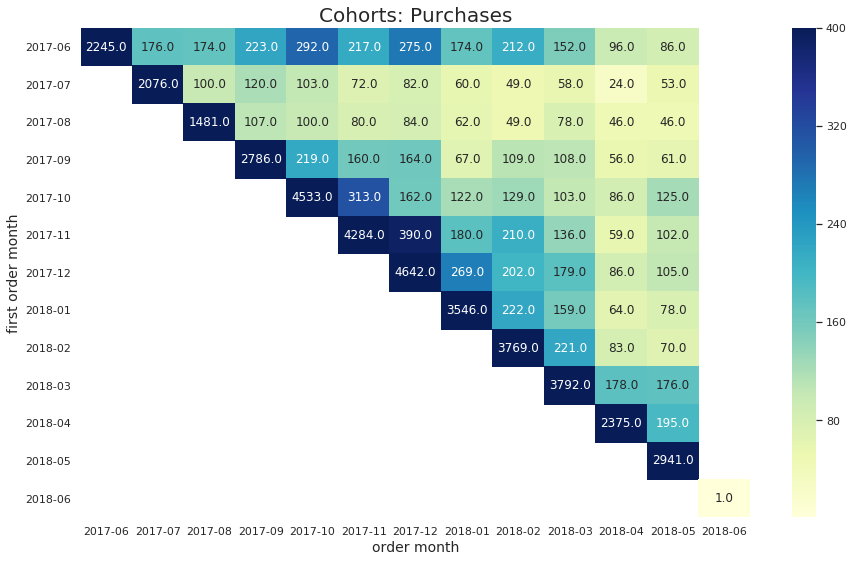

In [524]:
purchases = orders.pivot_table(index='first_order_month',
    columns='order_month',
    values='buy_ts',
    aggfunc='nunique')

sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Cohorts: Purchases', fontsize=20)
sns.heatmap(purchases, cmap="YlGnBu", annot=True, fmt='.5', vmax= 400, linecolor='gray', yticklabels=purchases.index.strftime('%Y-%m'), xticklabels=purchases.index.strftime('%Y-%m'))
plt.xlabel('order month', fontsize=14)
plt.ylabel('first order month', fontsize=14)

plt.show()

Очевидной зависимости изменения количества покупок со временем в пределах когорты не прослеживается.

Можно посчитать не по когортам, а в целом сколько покупок было совершено в каждый месяц:

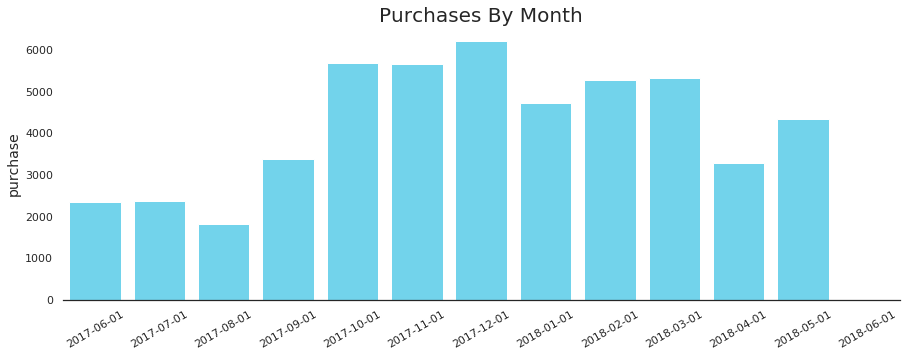

In [525]:
a=orders.groupby('order_month')['buy_ts'].count().reset_index()
a['order_month']=a['order_month'].astype('str')

plt.figure(figsize=(15, 5))
plt.title('Purchases By Month', fontsize=20)
sns.barplot(x='order_month', y='buy_ts', data=a, color="#5edfff", label="line")
sns.despine(left=True)
plt.xlabel('')
plt.ylabel('purchase', fontsize=14)
plt.xticks(rotation=30)
plt.show()

Видно, что количество покупок растет с сентября по май, и снижается в летний период. Активнее всего покупают в осенне-зимний период.

## Средний чек

In [526]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

In [527]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 8 columns):
buy_ts                  50415 non-null datetime64[ns]
revenue                 50415 non-null float64
uid                     50415 non-null uint64
first_ts_datetime       50415 non-null datetime64[ns]
start_to_buy_sec        50415 non-null int64
first_order_datetime    50415 non-null datetime64[ns]
order_month             50415 non-null datetime64[ns]
first_order_month       50415 non-null datetime64[ns]
dtypes: datetime64[ns](5), float64(1), int64(1), uint64(1)
memory usage: 3.5 MB


In [528]:
first_orders = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_ts']

first_visits = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
first_visits.columns = ['uid', 'first_visit_ts']

buyers = pd.merge(first_visits, first_orders, on='uid')
buyers['first_order_month'] = buyers['first_order_ts'].astype('datetime64[M]')

cohort_sizes = buyers.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.rename(columns={'uid': 'n_buyers'}, inplace=True)

cohorts = pd.merge(orders, buyers, how='inner', on=['uid', 'first_order_month'])\
    .groupby(['first_order_month', 'order_month'])\
    .agg({'revenue': ['sum', 'count']}).reset_index()
    
# Считаем возраст каждой когорты

cohorts['age_month'] = ((cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1,'M')).round()
cohorts.columns = ['first_order_month', 'order_month', 'revenue', 'n_orders', 'age_month']
    
# Добавляем в когортный отчет количество покупателей в каждой когорте 
# и считаем выручку и количество заказов на каждого покупателя.

cohorts_report = pd.merge(cohort_sizes, cohorts, on = 'first_order_month')
cohorts_report['rev_per_buyer'] = cohorts_report['revenue'] / cohorts_report['n_buyers']
cohorts_report['orders_per_buyer'] = cohorts_report['n_orders'] / cohorts_report['n_buyers']

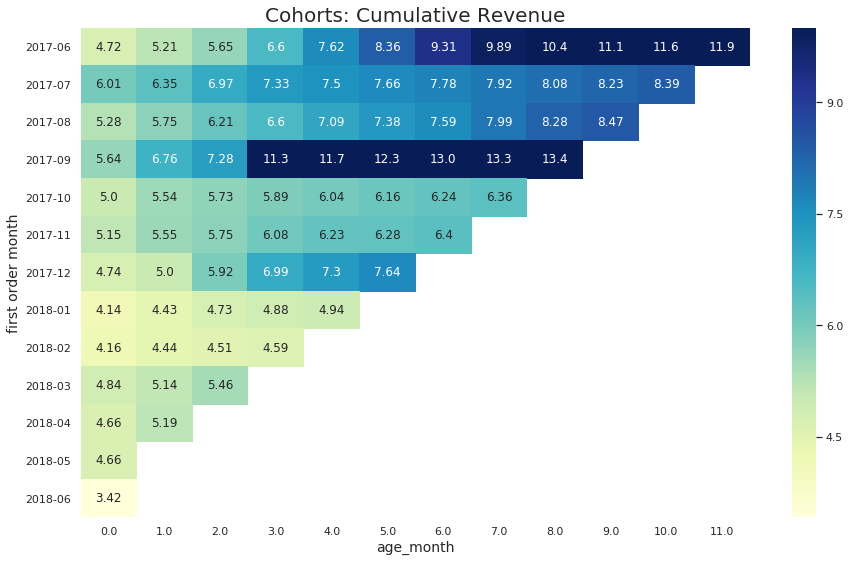

In [529]:
 # Возростной когортный отчет, показывающий накопительную выручку на покупателя

cohorts_age = cohorts_report.pivot_table(
index='first_order_month', 
columns='age_month', 
values='rev_per_buyer', 
aggfunc='sum'
).cumsum(axis=1)

#cohorts_age.fillna('') 

sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Cohorts: Cumulative Revenue', fontsize=20)
sns.heatmap(cohorts_age, cmap="YlGnBu", annot=True, fmt='.3', vmax= 10, linecolor='gray', yticklabels=cohorts_age.index.strftime('%Y-%m'),)
plt.xlabel('age_month', fontsize=14)
plt.ylabel('first order month', fontsize=14)

plt.show()

In [530]:
# Возростной когортный отчет, показывающий накопительное количество заказов и выручку на покупателя

cohorts_age = cohorts_report.pivot_table(
index='first_order_month', 
columns='age_month', 
values=['rev_per_buyer', 'orders_per_buyer'], 
aggfunc='sum'
).cumsum(axis=1)

display(cohorts_age.fillna(''))

orders_per_buyer                                      \
age_month                     0.0      1.0      2.0      3.0      4.0    
first_order_month                                                        
2017-06-01                1.163618  1.25111  1.33712  1.44884  1.59318   
2017-07-01                1.136765  1.18877  1.25117  1.30525  1.34269   
2017-08-01                1.118978  1.19781   1.2708  1.32993  1.39197   
2017-09-01                1.136381  1.22123  1.28361  1.34715  1.37311   
2017-10-01                1.143779  1.21613  1.25346  1.28157  1.31129   
2017-11-01                1.179368  1.27665  1.32124  1.37295  1.40627   
2017-12-01                1.152635  1.21424  1.26032  1.30116  1.32078   
2018-01-01                1.121554  1.18796   1.2351  1.25408   1.2772   
2018-02-01                1.121611  1.18242  1.20515  1.22432            
2018-03-01                1.168978  1.21936  1.26918                     
2018-04-01                1.096221   1.1819                              
2018-05-01                1.087349                                       
2018-06-01                1.000000                                       

                                                                ...  \
age_month             5.0      6.0      7.0      8.0      9.0   ...   
first_order_month                                               ...   
2017-06-01         1.70094  1.83737  1.92338  2.02818  2.10381  ...   
2017-07-01         1.38534  1.41706  1.44306  1.47322   1.4857  ...   
2017-08-01         1.43723  1.47299  1.52993   1.5635  1.59708  ...   
2017-09-01         1.41534  1.45719  1.47888  1.50252           ...   
2017-10-01         1.33502  1.35484  1.38364                    ...   
2017-11-01         1.42073  1.44572                             ...   
2017-12-01         1.34474                                      ...   
2018-01-01                                                      ...   
2018-02-01                                                      ...   
2018-03-01                                                      ...   
2018-04-01                                                      ...   
2018-05-01                                                      ...   
2018-06-01                                                      ...   

                  rev_per_buyer                                               \
age_month                  2.0      3.0      4.0      5.0      6.0      7.0    
first_order_month                                                              
2017-06-01              7.84115  8.79582  9.81835  10.5539  11.5043  12.0859   
2017-07-01              8.48222   8.8412  9.01799  9.17404  9.29424  9.43606   
2017-08-01              7.80407  8.19535   8.6894  8.97294  9.18361  9.58861   
2017-09-01              8.78556  12.7614  13.1619   13.809  14.5106  14.7537   
2017-10-01              7.11453  7.27168  7.42324   7.5436  7.62841  7.74388   
2017-11-01               7.1992  7.52415  7.67216  7.72604  7.84097            
2017-12-01               7.2684  8.33368  8.64661  8.98465                     
2018-01-01              6.01188  6.15465  6.21735                              
2018-02-01               5.7381  5.81224                                       
2018-03-01              6.72443                                                
2018-04-01                                                                     
2018-05-01                                                                     
2018-06-01                                                                     

                                                      
age_month             8.0      9.0      10.0    11.0  
first_order_month                                     
2017-06-01         12.6391  13.2449  13.8161  14.073  
2017-07-01          9.5973  9.74444  9.90011          
2017-08-01         9.88082  10.0688                   
2017-09-01         14.9377                            
2017-10-01                    

In [531]:
print('В среднем за 6 месяцев после первой покупки каждый покупатель делает {:.2f} заказа и приносит ${:.2f} выручки'\
  .format(cohorts_age['orders_per_buyer'][5].mean(), cohorts_age['rev_per_buyer'][5].mean()))

В среднем за 6 месяцев после первой покупки каждый покупатель делает 1.43 заказа и приносит $9.54 выручки


## Ценность клиента (LTV)

Чтобы решить эту задачу, следует посчитать "пожизненную" ценность клиента - метрику `LTV`.


`LTV` — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок. При расчёте `LTV` обычно обратимся к валовой прибыли с клиента за период.

Cформируем месячные когорты. Выделим месяцы из дат в таблицах с заказами и расходами:

In [532]:
costs['month'] = costs['dt'].astype('datetime64[M]')

Получим месяц первой покупки каждого покупателя:

In [533]:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
display(first_orders.head())

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


Посчитаем количество новых покупателей `n_buyers` за каждый месяц:

In [534]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
display(cohort_sizes.head())

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку.

In [535]:
cohorts_new = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
display(cohorts_new.head())

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


Строка таблицы `cohorts` показывает, какую выручку принесла когорта.

С точки зрения когортного анализа `LTV` — накопительная выручка когорты в пересчёте на количество людей. Добавим в таблицу `cohorts` данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [536]:
report = pd.merge(cohort_sizes, cohorts_new, on='first_order_month')
display(report.head())

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


Так как `LTV` считают не из выручки, а из валовой прибыли, нужно найти валовую прибыль, умножив выручку на маржинальность. 

`LTV` — относительный показатель. Значит его удобнее смотреть по «возрастным» когортам, где в столбцах — не месяц заказа, а возраст `age` когорты.

In [537]:
# Зададим маржинальность
margin_rate = 0.5

# Посчитаем валовую прибыль
report['gp'] = report['revenue'] * margin_rate

# Посчитаем возраст когорт
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

display(report.head())

,first_order_month,n_buyers,order_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,4778.745,0
1,2017-06-01,2023,2017-07-01,981.82,490.910,1
2,2017-06-01,2023,2017-08-01,885.34,442.670,2
3,2017-06-01,2023,2017-09-01,1931.30,965.650,3
4,2017-06-01,2023,2017-10-01,2068.58,1034.290,4


Найдём `LTV`. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. Для наглядности визуализируем когорты в виде тепловой карты:

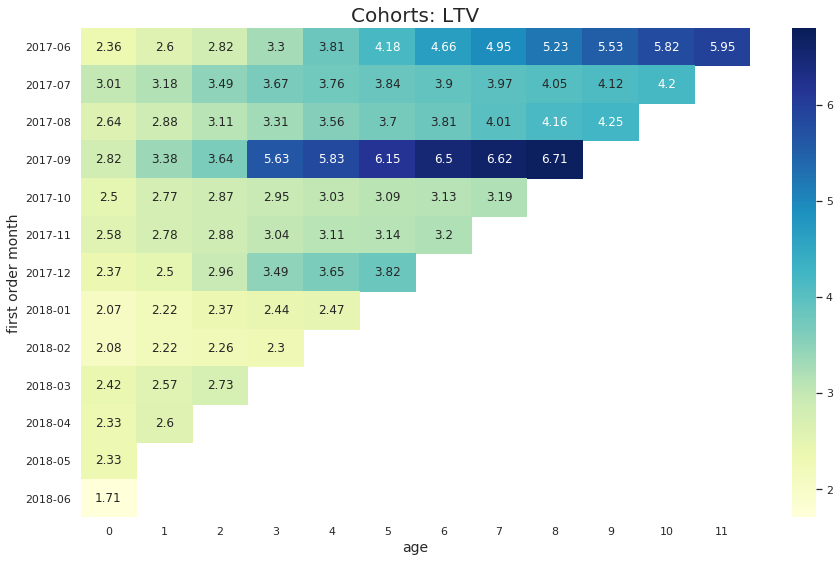

In [538]:
report['ltv'] = report['gp'] / report['n_buyers']

output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2).cumsum(axis=1)

output.fillna('')

sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Cohorts: LTV', fontsize=20)
sns.heatmap(output, cmap="YlGnBu", annot=True, fmt='.3', vmax= 6.8, linecolor='gray', yticklabels=output.index.strftime('%Y-%m'),)
plt.xlabel('age', fontsize=14)
plt.ylabel('first order month', fontsize=14)

plt.show()

В среднем при маржинальности 50% каждый покупатель из первой когорты принес около $6 рублей выручки за 12
месяцев «жизни». Сентябрьская когорта превзошла такие показатели уже на шестом месяце.

# <font color=green>Анализ маркетинговых каналов</font>

- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы?

In [539]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


## Затраты на маркетинг

In [540]:
costs_total = costs['costs'].sum()

print('Всего потратили (руб):', costs_total)

Всего потратили (руб): 329131.62


## Затраты по источникам 

In [541]:
costs_per_source = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index()
costs_per_source.columns = ['source_id', 'cost']
costs_per_source

,source_id,cost
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [542]:
from plotly import graph_objects as go

name = costs_per_source['source_id']
values = costs_per_source['cost']
colors=["#3B8CDC","#4DB8F8", "#3fc5f0", "#68DAF5", "#3276CE", "#204BA2", "#68DAF5"]

fig = go.Figure(data=[go.Pie(labels=name, values=values)])
fig.update_layout(
    title="Costs By Source",
    font=dict(
        family="Helvetica Neue",
        size=18
    ))
fig.update_traces(marker=dict(colors=colors))
fig.show()

На третий источник приходится чуть менее половины всех затрат.

## Затраты по месяцам

In [544]:
monthly_costs = costs.groupby('month')['costs'].sum().reset_index()
monthly_costs

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


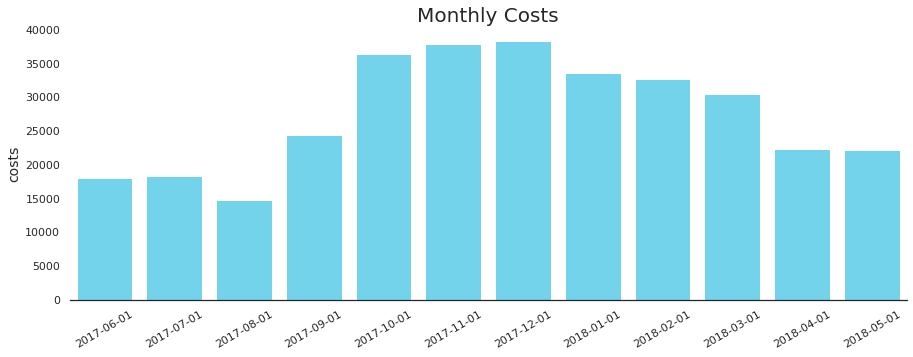

In [545]:
#monthly_costs.plot(grid=True)
monthly_costs['month_x'] = monthly_costs['month'].astype('str')

plt.figure(figsize=(15, 5))
plt.title('Monthly Costs', fontsize=20)
sns.barplot(x='month_x', y='costs', data=monthly_costs, color="#5edfff", label="line")
sns.despine(left=True)
plt.xlabel('')
plt.ylabel('costs', fontsize=14)
plt.xticks(rotation=30)

plt.show()

По графику видно, что расходы на маркетинг коррелируют с тем, сколько покупают за период.

## Стоимость привлечения одного покупателя из каждого источника

Чтобы найти стоимость привлечения покупателя из каждого источника, необходимо получить таблицу, содержащую информацию о первом заказе каждого пользователя и посчитать количество `uid` совершивших покупку.

In [546]:
orders.head()
#first_orders.head()

,buy_ts,revenue,uid,first_ts_datetime,start_to_buy_sec,first_order_datetime,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,60,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,660,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,120,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,900,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,1620,2017-06-01 07:58:00,2017-06-01,2017-06-01


Получим таблицу с первыми визитами пользователей по источникам

In [547]:
visits_uid = visits[['source_id', 'first_ts_month', 'uid']]
visits_uid.head()

,source_id,first_ts_month,uid
0,4,2017-12-01,16879256277535980062
1,2,2018-02-01,104060357244891740
2,5,2017-07-01,7459035603376831527
3,9,2018-03-01,16174680259334210214
4,3,2017-12-01,9969694820036681168


Присоединим к ней таблицу с первыми заказами по `uid`

In [548]:
visits_orders_uid = pd.merge(visits_uid, first_orders, on='uid', how='left')

# Так как нас интересуют только пользователи совершившие заказ, отбросим остальных
visits_orders_uid = visits_orders_uid.dropna()
visits_orders_uid.head()

,source_id,first_ts_month,uid,first_order_month
3,9,2018-03-01,16174680259334210214,2018-03-01
5,5,2017-09-01,16007536194108375387,2017-09-01
12,4,2017-06-01,8056418121947262981,2017-06-01
15,2,2018-02-01,18188358787673499603,2018-02-01
25,4,2017-09-01,2307401184189569202,2017-09-01


Сгруппируем таблицу по источнику и первому визиту, посчитаем количество уникальных покупателей

In [549]:
visits_by_source = (visits_orders_uid
    .groupby(['source_id', 'first_ts_month'], as_index=False)
    .agg({'uid': 'nunique', 'first_order_month': 'count'})
)
visits_by_source.columns = ['source_id', 'group_month', 'n_buyers', 'n_orders']
visits_by_source.head()

,source_id,group_month,n_buyers,n_orders
0,1,2017-06-01,706,4643
1,1,2017-07-01,565,1428
2,1,2017-08-01,368,829
3,1,2017-09-01,650,1228
4,1,2017-10-01,911,1508


Сгруппируем таблицу с затратами по источнику и месяцу

In [550]:
costs_by_source = costs.groupby(['source_id', 'month'], as_index=False)['costs'].sum()
costs_by_source.columns = ['source_id', 'group_month', 'costs']
costs_by_source.head()

,source_id,group_month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


Присоединим сгруппированную таблицу со стоимостями к таблице с визитами и количеством покупателей

In [551]:
costs_visits_by_source = pd.merge(visits_by_source, costs_by_source, on=['source_id', 'group_month'], how='outer')
costs_visits_by_source.head()
query_by_source = costs_visits_by_source.query('group_month > "2017-12-01"')
query_by_source.head()

,source_id,group_month,n_buyers,n_orders,costs
7,1,2018-01-01,530,848,2186.18
8,1,2018-02-01,533,893,2204.48
9,1,2018-03-01,488,764,1893.09
10,1,2018-04-01,303,528,1327.49
11,1,2018-05-01,351,424,1467.61


Создадим таблицу, сгруппированную по источнику, с количеством покупателей и затратами на маркетинг. Посчитаем стоимость покупателя за актуальный период (2018)

### CAC за 2018 год

,source_id,n_buyers,costs,cac
0,1,2205,9078.85,4.12
1,2,2161,18258.36,8.45
2,3,4445,60826.42,13.68
3,4,4839,26129.32,5.40
4,5,3254,22143.16,6.80
5,9,574,2314.61,4.03
6,10,703,2419.75,3.44


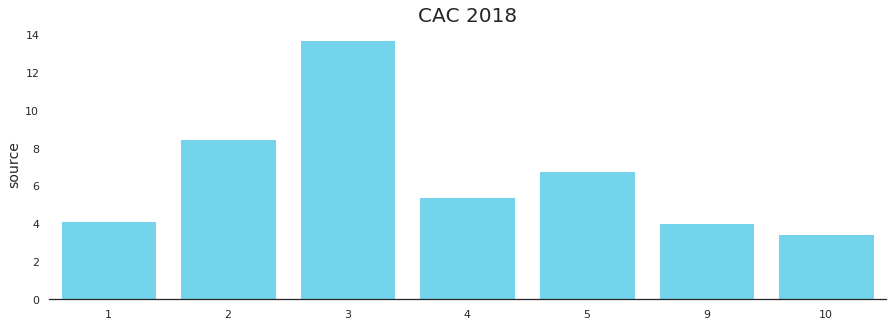

In [552]:
costs_visits_sum = query_by_source.groupby('source_id').agg({'n_buyers': 'sum', 'costs': 'sum'}).reset_index()
costs_visits_sum['cac'] = (costs_visits_sum['costs'] / costs_visits_sum['n_buyers']).round(2)
display(costs_visits_sum)

plt.figure(figsize=(15, 5))
plt.title('CAC 2018', fontsize=20)
sns.barplot(x='source_id', y='cac', data=costs_visits_sum, color="#5edfff", label="line")
sns.despine(left=True)
plt.xlabel('')
plt.ylabel('source', fontsize=14)

plt.show()

### CAC за весь период

,source_id,n_buyers,costs,cac
0,1,7138,20833.27,2.92
1,2,7305,42806.04,5.86
2,3,13846,141321.63,10.21
3,4,14253,61073.60,4.28
4,5,10156,51757.10,5.10
5,7,1,0.00,0.00
6,9,2793,5517.49,1.98
7,10,1773,5822.49,3.28


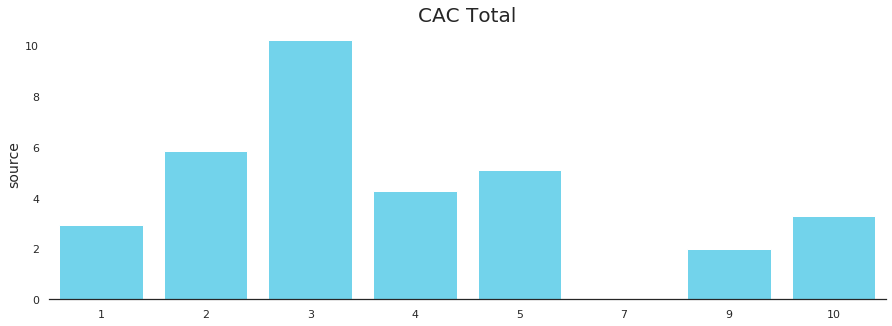

In [553]:
costs_visits_sum = costs_visits_by_source.groupby('source_id').agg({'n_buyers': 'sum', 'costs': 'sum'}).reset_index()
costs_visits_sum['cac'] = (costs_visits_sum['costs'] / costs_visits_sum['n_buyers']).round(2)
display(costs_visits_sum)

plt.figure(figsize=(15, 5))
plt.title('CAC Total', fontsize=20)
sns.barplot(x='source_id', y='cac', data=costs_visits_sum, color="#5edfff", label="line")
sns.despine(left=True)
plt.xlabel('')
plt.ylabel('source', fontsize=14)

plt.show()

Видно, что дороже всего по стоимости привлечения покупателей обходится третий канал. Наиболее выгодным по этому показателю можно считать четвертый канал, от него пришло большее количество покупателей, а затраты на маркетинг были в два раза меньше. Также стоит отметить первый канал, у него низкая стоимость привлечения покупателей, при сравнительно небольших затратах.

## Как окупаются расходы

Чтобы посмотреть как окупаются расходы на маркетинг посчитаем накопительную метрику - `ROI`. Для этого объединим report с затратами на маркетинг по месяцам, добавим столбец со стоимостью привлечения клиента

In [554]:
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv,month,costs,month_x,cac
0,2017-06-01,2023,2017-06-01,9557.49,4778.745,0,2.362207,2017-06-01,18015.0,2017-06-01,8.905091
1,2017-06-01,2023,2017-07-01,981.82,490.910,1,0.242664,2017-06-01,18015.0,2017-06-01,8.905091
2,2017-06-01,2023,2017-08-01,885.34,442.670,2,0.218819,2017-06-01,18015.0,2017-06-01,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,965.650,3,0.477336,2017-06-01,18015.0,2017-06-01,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,1034.290,4,0.511265,2017-06-01,18015.0,2017-06-01,8.905091


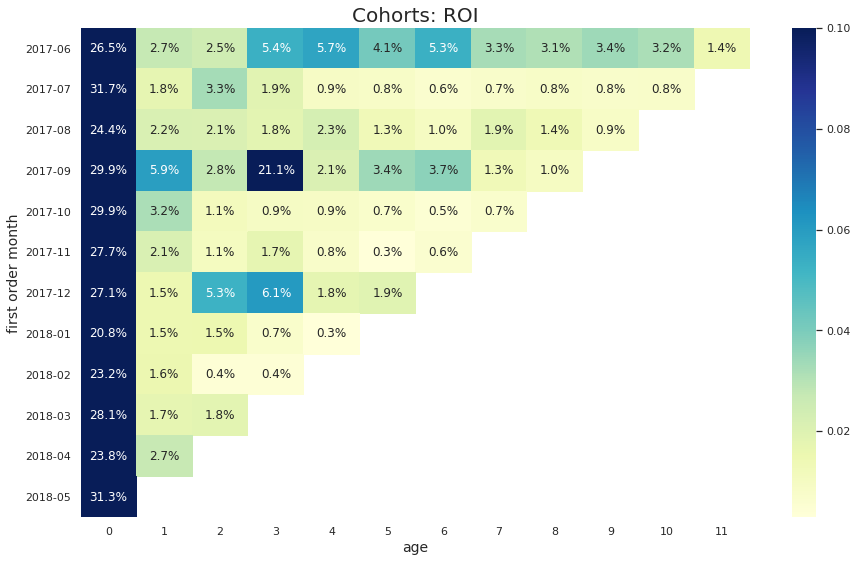

In [555]:
report_new['romi'] = report_new['ltv'] / report_new['cac']

output = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

output.cumsum(axis=1).round(2).fillna('')

sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Cohorts: ROI', fontsize=20)
sns.heatmap(output, cmap="YlGnBu", annot=True, fmt='.1%', vmax= 0.1, linecolor='gray', yticklabels=output.index.strftime('%Y-%m'),)
plt.xlabel('age', fontsize=14)
plt.ylabel('first order month', fontsize=14)

plt.show()

Судя по таблице, ни в одной когорте расходы еще не окупились, но быстрее всего окупается июньская, сентябрьская и декабрьская когорты. Резкий скачок в сентябрьской когорте произошел между третьим и четвертым месяцем жизни. 

In [556]:
roi_total = ((report_new['revenue'].sum()) - costs_total)*100 / costs_total
print('Текущий суммарный ROMI:', roi_total.round(), '%')

Текущий суммарный ROMI: -23.0 %


Теперь посчитаем `ROI` по источникам:

In [557]:
#Объединим таблицы, чтобы получить 'source_id', 'revenue', 'costs' в одной, необходимые для рассчета ROI

orders_roi = orders[['revenue', 'uid']]
visits_roi = visits[['source_id', 'uid', 'first_ts_datetime']]

# Одному и тому же uid могут соответствовать несколько рекламных источников 
# Выявим из какого источника был совершен перавй заход, удалим дублирующие значения

visits_roi = visits_roi.groupby(['uid', 'source_id'], as_index=False)['first_ts_datetime'].min()
visits_roi = visits_roi.drop_duplicates(subset=['uid','first_ts_datetime'])

#print(visits_roi.query('uid == "3993697860786194247"'))

roi_table = pd.merge(orders_roi, visits_roi, on='uid')
#roi_table

revenue_by_source = roi_table.groupby('source_id', as_index=False).agg({'revenue': 'sum'})
#revenue_by_source

costs_roi = costs.groupby('source_id', as_index=False)['costs'].sum()
#costs_roi

roi_total = revenue_by_source.merge(costs_roi, on='source_id')
roi_total['roi'] = ((roi_total['revenue'] - roi_total['costs'])*100/ roi_total['costs']).round(2)

display(roi_total)
print('Revenue total:', (roi_total['revenue'].sum()).round(2))
print('Costs total:', (roi_total['costs'].sum()).round(2))

,source_id,revenue,costs,roi
0,1,101631.38,20833.27,387.83
1,2,43123.74,42806.04,0.74
2,3,43354.82,141321.63,-69.32
3,4,36705.84,61073.60,-39.90
4,5,22919.80,51757.10,-55.72
5,9,1874.18,5517.49,-66.03
6,10,2446.22,5822.49,-57.99


Revenue total: 252055.98
Costs total: 329131.62


`ROI` по каналам показывает, что лучше всех окупился первый канал, показатель `ROI` которого почти 400%, также на окупаемость вышел канал `№2`.

# Вывод:


На основании проведенного анализа, отделу маркетинга можно дать следующие рекомендации:

- перераспределить бюджет по источникам. Сейчас практически половина бюждета выделена на канал, который приносит самых дорогих клиентов и имеет самый низкий `ROI` по сравнению с остальными каналами. На основании стоимости привлечения покупателя можно выделить источник **`№4`** как наиболее перспективный. Он показывает хорошие показатели при сравнительно высоком бюджете, то есть он уже достаточно масштабирован, чтобы делать выводы. Этот источник приводит больше покупателей, чем `№3` (на который уходит большая часть бюджета) и при этом расходы на канал `№4` в два раза меньше, чем на `№3`. 

- по показателю `ROI` абсолбтно точно стоит увеличить бюджет на канал `№1`, а также масштабировать канал `№2`, но принимать во внимание высокую стоимость привлечения клиентов.

Для детальных рекомендаций надо провести более глубокий маркетинговый анализ источников/платформ.  